# Logistic Regression

The most common way to do Bayesian Logistic Regression is to use the Laplace Approximation.

## The Model

The model is the same as Linear Regression, except the output is passed through a Logistic Sigmoid to give output that is on [0,1].

$P(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$

$P(\mathbf{y} \mid \mathbf{X}, \mathbf{w} ) = \sigma(\mathcal{N}(\mathbf{Xw}, \beta^{-1}\mathbf{I}))$

## No More Conjugacy

This model is not conjugate - what we typically do is is approximate the posterior with a Normal distribution. This is a useful approximation, as we then have a conjugate posterior-likelihood pair. This means if we want a predictive distribution, everything is easy.

## Laplace Approximation Recap


We want to approximate a distribution, $\frac{1}{Z} f(Z)$. 

Using the Taylor series about a point $Z_{0}$ of $ln \ f(Z)$:

$ln \ f(Z) \approxeq ln \ f(Z_{0})+ \frac{1}{f(Z_{0})} [\frac{d}{dZ}f(Z) \mid_{Z_{0}}](Z-Z_{0}) + \frac{1}{2} [\frac{d^{2}}{dZ^{2}} ln \ f(Z) \mid_{Z_{0}}](Z-Z_{0})^{2}$

Because we say $Z_{0}$ is the mode, the middle term disappears (as derivative is 0 at mode).

$ln \ f(Z) \approxeq ln \ f(Z_{0})-\frac{1}{2} A(Z-Z_{0})^{2}$

Which is a log gaussian with mean $Z_{0}$ and variance $A^{-1}$.

For more details see PRML, Bishop.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.datasets import make_classification
%matplotlib inline

In [54]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(LogisticRegression, self).__init__()
        self.w = torch.nn.Linear(in_features, out_features, bias=False)
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.sigmoid = torch.nn.Sigmoid()
        self.prior_mean = torch.from_numpy(np.zeros((in_features,))).float()
        self.prior_cov = torch.from_numpy(np.identity(in_features)*1/200.).float()
        
    def forward(self, x):
        return self.w(x)
    
    def forward_with_softmax(self, x):
        return self.sigmoid(self.forward(x))
    
    def loss(self, x, y):
        y_hat = self.forward(x)
        l2 = self.NLL_prior(self.w.weight)
        return self.bce(y_hat, y) + l2
    
    def NLL_prior(self, w):
        dw = w-self.prior_mean
        return torch.matmul(torch.matmul(dw, self.prior_cov), dw.transpose(0,1))
        

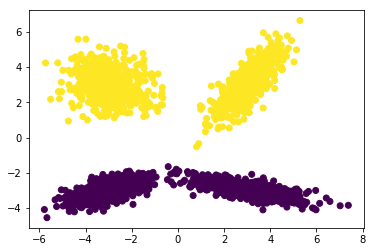

In [151]:
x, y = make_classification(n_samples=2000, flip_y=0, n_features=2, n_informative=2, n_redundant=0, class_sep=3.0)
plt.scatter(x[:,0], x[:,1], c=y)
x_1s = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)

In [152]:
lr = LogisticRegression(x_1s.shape[1],1)

In [153]:
opt = torch.optim.Adam(lr.parameters(), lr=0.05)

In [154]:
x_t = torch.autograd.Variable(torch.from_numpy(x_1s).float())
y_t = torch.autograd.Variable(torch.from_numpy(y.reshape(-1,1)).float())
for t in range(5000):
    opt.zero_grad()
    loss = lr.loss(x_t,y_t)
    loss.backward()
    opt.step()

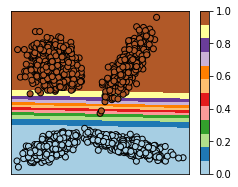

In [155]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy_1s = np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]

Z = lr.forward_with_softmax(torch.from_numpy(xy_1s).float()).data.numpy()

# Put the result into a cololr plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()

In [156]:
y_hat = lr.forward_with_softmax(x_t)

In [157]:
lpl_mean = lr.w.weight
lpl_prec = torch.inverse(lr.prior_cov)+torch.matmul(torch.matmul(x_t.transpose(0,1), torch.diagflat(y_hat*(1-y_hat)) ), x_t)

In [158]:
mvn = torch.distributions.MultivariateNormal(lpl_mean, torch.inverse(lpl_prec))

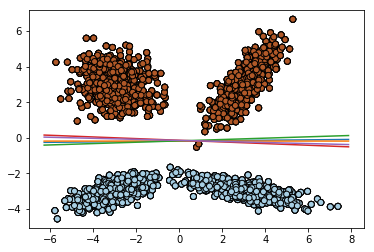

In [159]:
for i in range(5):
    w_sample =  mvn.sample().data.numpy().ravel()
    x1 = np.arange(x_min, x_max, h)
    x2  =(-w_sample[0] - x1*w_sample[1])/w_sample[2]
    plt.plot(x1,x2)
    plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.ylim([y_min,y_max])

In [160]:
# Can use posterior to compute bayesian predictive distribution. If we pick a data point far from our data:

x_pred = np.array([1.,100.,.5]).reshape(1,-1)
x_pred_t = torch.from_numpy(x_pred).float()

In [161]:
av = 0.0
for i in range(30):
    w_sample =  mvn.sample()
    p_y = torch.nn.functional.sigmoid(torch.matmul(x_pred_t, w_sample.transpose(0,1)))
    av += p_y.data.numpy()
    
print("Bayesian Preditive probability that this point is class 1 is:",av.ravel()[0]/30.)

Bayesian Preditive probability that this point is class 1 is: 0.821163050334


In [163]:
likelihood_pred = lr.forward_with_softmax(x_pred_t).data.numpy()

print("Niave use of the likelihood function predicts that the probability this point is class 1 is:"
      ,likelihood_pred.ravel()[0])

Niave use of the likelihood function predicts that the probability this point is class 1 is: 0.987185


# Summary

The laplace approximation is an analytical approximation based on the taylor series about the mode of the posterior. This works reasonably well, but is not general.